In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
historical_data = yf.download('0005.hk',"2017-09-28","2021-09-24")
historical_data.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
data=pd.DataFrame()
data["Open"]=historical_data['Open']
data["High"]=historical_data['High']
data["Low"]=historical_data['Low']
data["Close"]=historical_data['Close']
data['H-L'] = historical_data['High'] - historical_data['Low']
data['O-C'] = historical_data['Close'] - historical_data['Open']
# data["% Change"]=historical_data["Close"].pct_change()
data['7day MA'] = historical_data['Close'].shift(1).rolling(window = 5).mean()
data['14day MA'] = historical_data['Close'].shift(1).rolling(window = 10).mean()
data['21day MA'] = historical_data['Close'].shift(1).rolling(window = 20).mean()
data['Std_dev']= historical_data['Close'].shift(1).rolling(7).std()
data['RSI'] = talib.RSI(historical_data['Close'].values, timeperiod = 5)
data

,Open,High,Low,Close,H-L,O-C,7day MA,14day MA,21day MA,Std_dev,RSI
Date,,,,,,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,1.049995,-0.200005,NaN,NaN,NaN,NaN,NaN
2017-09-29,76.500000,76.900002,76.300003,76.550003,0.599998,0.050003,NaN,NaN,NaN,NaN,NaN
2017-10-03,76.800003,77.449997,76.699997,77.449997,0.750000,0.649994,NaN,NaN,NaN,NaN,NaN
2017-10-04,77.500000,77.949997,77.500000,77.849998,0.449997,0.349998,NaN,NaN,NaN,NaN,NaN
2017-10-06,77.599998,77.800003,77.199997,77.349998,0.600006,-0.250000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16,40.599998,40.599998,39.599998,40.000000,1.000000,-0.599998,40.460001,40.795000,41.3775,0.342436,21.654758
2021-09-17,39.700001,40.400002,39.099998,40.250000,1.300003,0.549999,40.380000,40.660001,41.2600,0.324588,37.268919
2021-09-20,39.900002,39.950001,38.950001,39.000000,1.000000,-0.900002,40.250000,40.540001,41.1700,0.327509,16.596261


In [4]:
data.dropna(inplace=True)

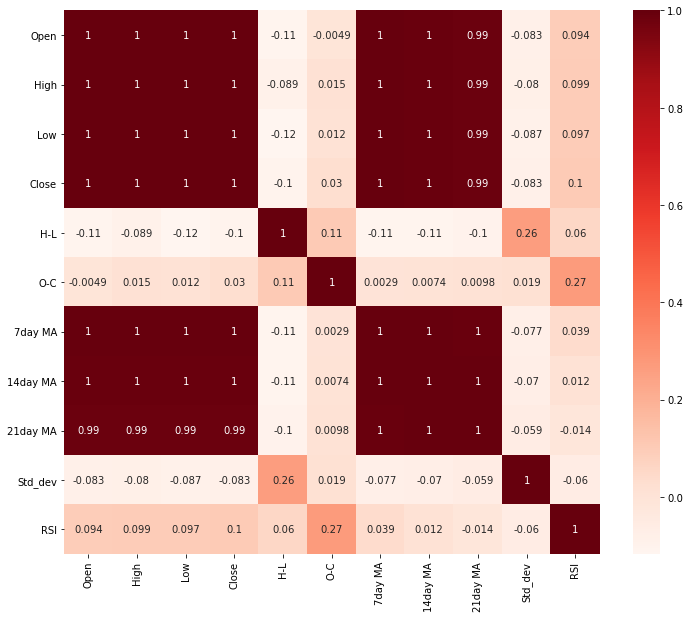

In [5]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [6]:
data.drop(["RSI","H-L","O-C","Std_dev"],1,inplace=True)

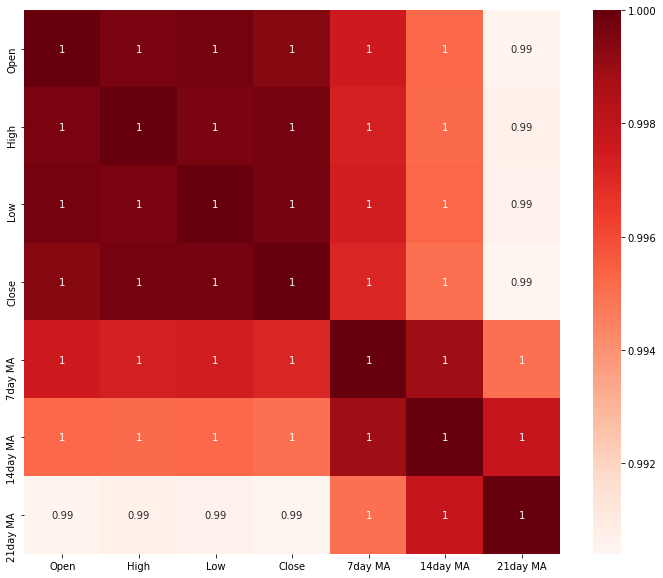

Open        0.999379
High        0.999713
Low         0.999707
Close       1.000000
7day MA     0.997147
14day MA    0.995021
21day MA    0.990396
Name: Close, dtype: float64

In [7]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
#Correlation with output variable
cor_target = abs(cor["Close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
X=scaler.fit_transform(data.drop("Close",1))
y=data["Close"]

In [9]:
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        print(data[i:(i+lb)])
        Y.append(data_price[(i+lb)])
    return np.array(X),np.array(Y)

In [10]:
lb=5
X,y = processData(X,y.values,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

[[0.84735467 0.86137756 0.85306828 0.84485488 0.84600897 0.86548681]
 [0.83087597 0.83609413 0.83923949 0.84608619 0.84520179 0.86608752]
 [0.83000862 0.83958157 0.84183229 0.84503077 0.84349774 0.86576406]
 [0.8291414  0.82911939 0.83491797 0.84485488 0.84286994 0.86502472]
 [0.81873379 0.82301654 0.82973209 0.84116094 0.84260088 0.86317638]]
[[0.83087597 0.83609413 0.83923949 0.84608619 0.84520179 0.86608752]
 [0.83000862 0.83958157 0.84183229 0.84503077 0.84349774 0.86576406]
 [0.8291414  0.82911939 0.83491797 0.84485488 0.84286994 0.86502472]
 [0.81873379 0.82301654 0.82973209 0.84116094 0.84260088 0.86317638]
 [0.81786643 0.81691369 0.81849611 0.8358839  0.84098653 0.86155908]]
[[0.83000862 0.83958157 0.84183229 0.84503077 0.84349774 0.86576406]
 [0.8291414  0.82911939 0.83491797 0.84485488 0.84286994 0.86502472]
 [0.81873379 0.82301654 0.82973209 0.84116094 0.84260088 0.86317638]
 [0.81786643 0.81691369 0.81849611 0.8358839  0.84098653 0.86155908]
 [0.81439728 0.82737574 0.826274

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))
model.compile(
  loss='mean_squared_error',
  optimizer='Adam'
)

In [12]:
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/300
27/27 [==============================] - 10s 25ms/step - loss: 4675.8410 - val_loss: 676.9763
Epoch 2/300
27/27 [==============================] - 0s 5ms/step - loss: 2136.9465 - val_loss: 36.1740
Epoch 3/300
27/27 [==============================] - 0s 6ms/step - loss: 878.6020 - val_loss: 73.7515
Epoch 4/300
27/27 [==============================] - 0s 6ms/step - loss: 387.2349 - val_loss: 165.0259
Epoch 5/300
27/27 [==============================] - 0s 6ms/step - loss: 277.5415 - val_loss: 148.5109
Epoch 6/300
27/27 [==============================] - 0s 5ms/step - loss: 262.0898 - val_loss: 6.0914
Epoch 7/300
27/27 [==============================] - 0s 5ms/step - loss: 252.2049 - val_loss: 69.7994
Epoch 8/300
27/27 [==============================] - 0s 5ms/step - loss: 116.9988 - val_loss: 33.5118
Epoch 9/300
27/27 [==============================] - 0s 5ms/step - loss: 90.9986 - val_loss: 3.2660
Epoch 10/300
27/27 [==============================] - 0s 5ms/step - loss: 138.

Epoch 82/300
27/27 [==============================] - 0s 5ms/step - loss: 4.9100 - val_loss: 0.6546
Epoch 83/300
27/27 [==============================] - 0s 5ms/step - loss: 5.0029 - val_loss: 0.6487
Epoch 84/300
27/27 [==============================] - 0s 5ms/step - loss: 5.1200 - val_loss: 0.6419
Epoch 85/300
27/27 [==============================] - 0s 5ms/step - loss: 5.2281 - val_loss: 0.6350
Epoch 86/300
27/27 [==============================] - 0s 5ms/step - loss: 5.3324 - val_loss: 0.6293
Epoch 87/300
27/27 [==============================] - 0s 5ms/step - loss: 5.4440 - val_loss: 0.6242
Epoch 88/300
27/27 [==============================] - 0s 5ms/step - loss: 5.5569 - val_loss: 0.6199
Epoch 89/300
27/27 [==============================] - 0s 5ms/step - loss: 5.6676 - val_loss: 0.6166
Epoch 90/300
27/27 [==============================] - 0s 5ms/step - loss: 5.7771 - val_loss: 0.6141
Epoch 91/300
27/27 [==============================] - 0s 5ms/step - loss: 5.8863 - val_loss: 0.6125


Epoch 163/300
27/27 [==============================] - 0s 5ms/step - loss: 7.6710 - val_loss: 0.9466
Epoch 164/300
27/27 [==============================] - 0s 5ms/step - loss: 8.4926 - val_loss: 0.9681
Epoch 165/300
27/27 [==============================] - 0s 5ms/step - loss: 3.8234 - val_loss: 0.7612
Epoch 166/300
27/27 [==============================] - 0s 5ms/step - loss: 3.1316 - val_loss: 0.7392
Epoch 167/300
27/27 [==============================] - 0s 5ms/step - loss: 3.2742 - val_loss: 0.9320
Epoch 168/300
27/27 [==============================] - 0s 5ms/step - loss: 2.5229 - val_loss: 0.8517
Epoch 169/300
27/27 [==============================] - 0s 6ms/step - loss: 4.4038 - val_loss: 0.7437
Epoch 170/300
27/27 [==============================] - 0s 5ms/step - loss: 5.8910 - val_loss: 0.8089
Epoch 171/300
27/27 [==============================] - 0s 5ms/step - loss: 4.1532 - val_loss: 0.7512
Epoch 172/300
27/27 [==============================] - 0s 5ms/step - loss: 2.5118 - val_los

27/27 [==============================] - 0s 5ms/step - loss: 3.5831 - val_loss: 0.8368
Epoch 245/300
27/27 [==============================] - 0s 5ms/step - loss: 3.5376 - val_loss: 0.8465
Epoch 246/300
27/27 [==============================] - 0s 5ms/step - loss: 3.4969 - val_loss: 0.8532
Epoch 247/300
27/27 [==============================] - 0s 5ms/step - loss: 3.4610 - val_loss: 0.8567
Epoch 248/300
27/27 [==============================] - 0s 5ms/step - loss: 3.4300 - val_loss: 0.8573
Epoch 249/300
27/27 [==============================] - 0s 5ms/step - loss: 3.4038 - val_loss: 0.8551
Epoch 250/300
27/27 [==============================] - 0s 5ms/step - loss: 3.3823 - val_loss: 0.8503
Epoch 251/300
27/27 [==============================] - 0s 5ms/step - loss: 3.3655 - val_loss: 0.8431
Epoch 252/300
27/27 [==============================] - 0s 5ms/step - loss: 3.3534 - val_loss: 0.8339
Epoch 253/300
27/27 [==============================] - 0s 5ms/step - loss: 3.3458 - val_loss: 0.8229
Epoc

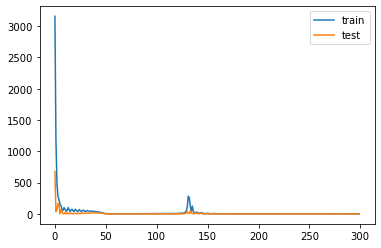

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [14]:
y_pred = model.predict(X_test)

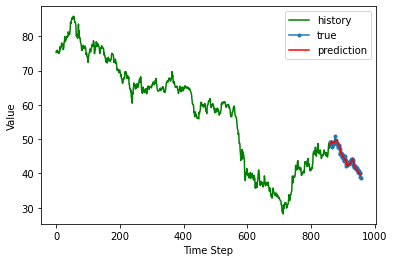

In [15]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

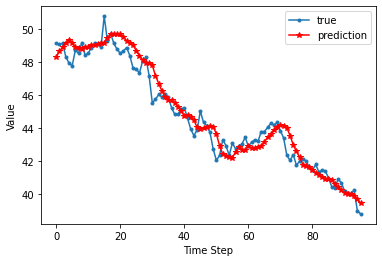

In [22]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [24]:
y_test.shape

(96, 1)

In [23]:
y_pred.shape

(96, 1)

In [19]:
mean_absolute_percentage_error(y_test,y_pred)

0.012436394662404046

In [20]:
mean_squared_error(y_test,y_pred)

0.5157382942308383

In [21]:
def MBE(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Biais score
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = (y_true-y_pred)
    mbe = diff.mean()
    print('MBE = ', mbe)

MBE(y_test,y_pred)

MBE =  -0.1709650754928589
